# Mediana dla obrazu kolorowego

Idea filtracji medianowej jest dość prosta dla obrazów w odcieniach szarości.
Dla obrazów kolorowych trudniej jest określić kryterium wg. którego szeregowane będą wartości, z których wyznaczana będzie mediana.

Jedną z możliwości wykonania filtracji medianowej dla obrazów kolorowych (na podstawie *The Image Processing Handbook*, J. Russ) jest wykorzystanie następującej definicji mediany:
``mediana to ten piksel z otoczenia, którego odległość do innych pikseli z otoczenia jest najmniejsza''.
Jako miarę odległości wykorzystujemy pierwiastek z sumy kwadratów różnic poszczególnych składowych R,G,B.
Zatem odległość między dwoma pikselami wyraża się wzorem:
\begin{equation}
dRGB = \sqrt{(R_1-R_2)^2+(G_1-G_2)^2+(B_1-B_2)^2}
\end{equation}

Warto zwrócić uwagę, że istnieje wiele możliwości zdefiniowania porównywania wielkości wektorowych (jeden piksel to wektor o trzech składowych).
Można zamiast odległości wykorzystać kąt albo połączyć oba parametry.
Ponadto istnieje możliwość dodania do wektora dodatkowych składowych - tak aby lepiej opisać piksel.

Celem zadania jest implementacja opisanego algorytmu.

1. Wczytaj obraz *lenaRGBSzum.png* (dostępny na git).
2. Zdefiniuj rozmiar okna.
3. Wykonaj pętle po pikselach, dla których okno jest zdefiniowane (pomiń brzeg obrazu).
4. Dla każdego piksela pobierz okno o właściwym rozmiarze.
5. Wykonaj pętle po oknie, wewnątrz której obliczona zostanie suma odległości.
    - Obliczanie różnicy: `window - window[rowWin, colWin]`.
    - Obliczanie kwadratów: `np.square`.
    - Obliczanie pierwiastka: `np.sqrt`.
    - Obliczanie sumy metodą `.sum`.
6. Po obliczeniu macierzy odległości wyznacz argument elementu minimalnego.
Wykorzystaj funkcję `np.argmin`.
Argument funkcji zostanie spłaszczony, jeśli ma więcej niż jeden wymiar.
Aby przekonwertować spłaszczony indeks na indeks macierzy wykorzystaj funkcję `np.unravel_index`.
7. Przypisz odpowiedni wektor wartości do piksela obrazu wynikowego.
8. Wyświetl obraz oryginalny i przefiltrowany.
9. Przeprowadź dwa eksperymenty - dla obrazu _lenaRGB_ oraz _lenaRGBszum_.

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/06_Context/"

LENA_FILENAME = "lenaRGB.png"
LENA_NOISE_FILENAME = "lenaRGBSzum.png"

for filename in [LENA_FILENAME, LENA_NOISE_FILENAME]:
    if not os.path.exists(filename):
        r = requests.get(url + filename, allow_redirects=True)
        open(filename, "wb").write(r.content)

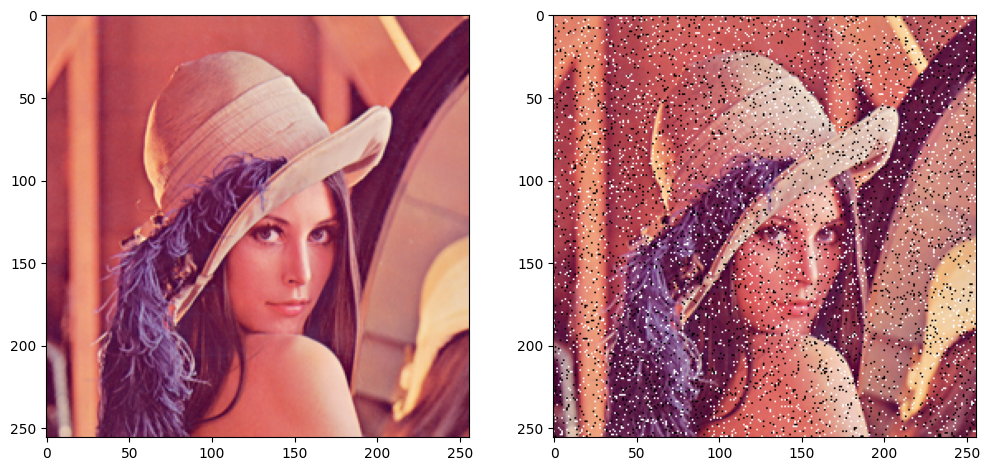

In [2]:
lena_image, lena_noise_image = [
    cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    for filename in [LENA_FILENAME, LENA_NOISE_FILENAME]
]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(lena_image)
ax2.imshow(lena_noise_image)

In [5]:
from math import sqrt, floor


def pixel_difference(pixel1, pixel2):
    return sqrt(sum([(c1 - c2) ** 2 for c1, c2 in zip(pixel1, pixel2)]))


def get_neighbouring_pixels(image, point, frame_size):
    rows, cols, _ = image.shape
    pix_y, pix_x = point
    radius = floor(frame_size / 2)

    result = []
    for y in range(max(0, pix_y - radius), min(rows, pix_y + radius + 1)):
        for x in range(max(0, pix_x - radius), min(cols, pix_x + radius + 1)):
            result.append(image[y, x].tolist())
    return result


def get_median_pixel(pixels):
    distances = [[pixel_difference(p1, p2) for p1 in pixels] for p2 in pixels]

    sum_of_distances = [sum(dist) for dist in distances]

    return pixels[np.argmin(sum_of_distances)]


def filter_median(image, frame_size=3):
    rows, cols, _ = image.shape

    result = np.zeros(shape=image.shape, dtype=image.dtype)
    for y in range(rows):
        for x in range(cols):
            neighbours = get_neighbouring_pixels(
                image, point=(y, x), frame_size=frame_size
            )
            result[y][x] = get_median_pixel(neighbours)

    return result

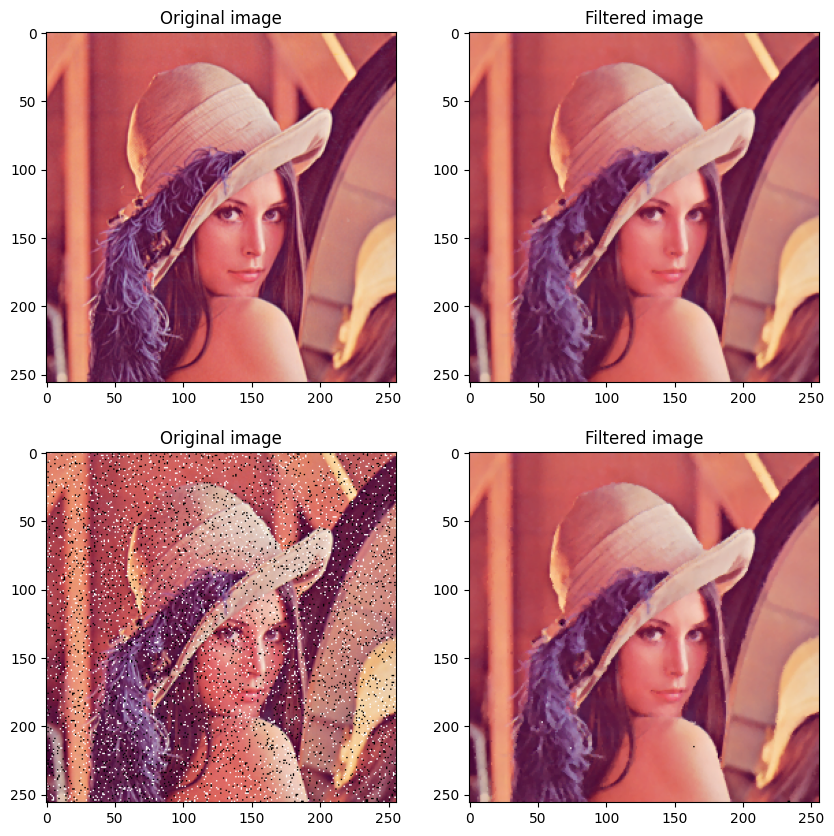

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

for (ax1, ax2), image in zip(axs, [lena_image, lena_noise_image]):
    filtered_image = filter_median(image)

    ax1.set_title("Original image")
    ax1.imshow(image)

    ax2.set_title("Filtered image")
    ax2.imshow(filtered_image)